In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model, save_model

import seaborn as sns
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import time

import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

WINDOW = 22

Using TensorFlow backend.


In [2]:
df = pd.read_csv("../data/data_18_07.csv", delimiter=',', index_col=0)
splitFrame = pd.DataFrame(df.date_time.str.split(' ',1).tolist(), columns = ['date','time'],index = df.index)
df = pd.concat([splitFrame, df[df.columns[2:]]], axis=1)
df.head()

,date,time,open,close,low,high,volume,pair_id
#,,,,,,,,
1,2015-08-01,07:00:00.000000,284.000000,279.845023,275.724508,284.000000,301.376392,83
2,2015-08-02,07:00:00.000000,280.000000,286.438075,280.000000,286.438075,106.563859,83
3,2015-08-03,07:00:00.000000,285.438300,288.965644,284.286275,288.965644,75.706794,83
4,2015-08-04,07:00:00.000000,281.104486,288.000000,281.104486,288.000000,11.947218,83
5,2015-08-05,07:00:00.000000,288.200000,287.569800,279.793314,288.965425,9.297527,83


In [3]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

all_df = df.copy()

x = all_df[['open', 'low', 'high', 'volume']].copy()
y = all_df['close'].copy()

x[['open', 'low', 'high', 'volume']] = x_scaler.fit_transform(x)

y = y_scaler.fit_transform(y.values.reshape(-1, 1))

In [7]:
def load_data(X, seq_len, train_size=1):
    
    amount_of_features = X.shape[1] 
    X_mat = X.as_matrix() 
    
    sequence_length = seq_len + 1 
    data = []
    
    for index in range(len(X_mat)+1 - sequence_length):
        data.append(X_mat[index: index + sequence_length])
    
    data = np.array(data)
    train_split = int(round(train_size * data.shape[0]))
    train_data = data[:train_split, :]
    
    x_train = train_data[:, :-1]
    y_train = train_data[:, -1][:,-1]
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))

    return x_train, y_train

In [9]:
window = 22
x['close'] = y
X_train, y_train, X_test, y_test = load_data(x, window)
print (X_train.shape, y_train.shape)

(696, 22, 5) (696,) (0, 22, 5) (0,)


In [10]:
def build_model(input_shape):
    d = 0.2
    model = Sequential()
    
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(128, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="normal",activation='relu'))        
    model.add(Dense(1,kernel_initializer="normal",activation='linear'))
    
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    
    return model

In [12]:
model = build_model(input_shape=(window, 5))

In [13]:
print('START FIT MODEL...')
start = time.time()
model.fit(X_train, y_train, batch_size=32, epochs=500,
          verbose=0)
end = time.time()

print ('Learning time: ', end-start)

START FIT MODEL...
Learning time:  407.4381227493286


In [14]:
save_model(model, "../modelOneFeature/model_btc_close_5Feature_18_07.h5")

In [26]:
model = load_model("../modelOneFeature/model_btc_close_5Feature_18_07.h5")

In [16]:
trainPredict = model.predict(X_train)
trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([y_train])

trainScore = metrics.mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 36.86 RMSE


In [17]:
prices = all_df.close.values.astype('float32')
prices = prices.reshape(len(prices), 1)

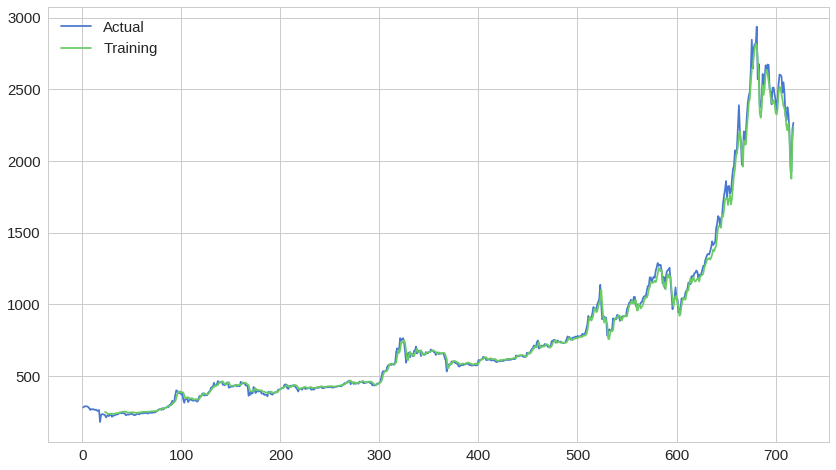

In [18]:
trainPredictPlot = np.empty_like(prices)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[WINDOW:len(trainPredict)+WINDOW, :] = trainPredict

plt.plot(pd.DataFrame(prices, columns=["close"], index=all_df.index).close, label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=all_df.index).close, label='Training')
plt.legend(loc='best')
plt.show()


In [33]:
import datetime 

def predictNumDay(num):
    m = load_model("../modelOneFeature/model_btc_close_5Feature_18_07.h5")
    
    prediction = []
    lastbatch = np.array(x[-WINDOW:])
    print (lastbatch.shape)
    for i in np.arange(num):    
        res = m.predict([lastbatch.reshape(1,22, 5)])
        prediction.append(y_scaler.inverse_transform(res))
        print (lastbatch.shape, res.shape)
#        lastbatch = np.concatenate([lastbatch[1:].reshape(1,22, 5),res])
#        m.train_on_batch(lastbatch.reshape(1,22,5), res)
    
    return np.array(prediction).reshape(num)   

N = 1

lastDate =str(df.date[df.last_valid_index()]).split('-')
currentData = datetime.date(int(lastDate[0]),int(lastDate[1]),int(lastDate[2])+1)
predictionDate = pd.date_range(currentData,periods=N)
print (predictionDate)

predict5day =  (predictNumDay(N))
print (predict5day)

prediction = pd.DataFrame(predict5day, columns=["predictionPrice"], index = predictionDate.values)

DatetimeIndex(['2017-07-19'], dtype='datetime64[ns]', freq='D')
(22, 5)
(22, 5) (1, 1)
[ 2199.35327148]


In [23]:
# predict next day besides train data

alldata = x_scaler.fit_transform(df['close'].values)
data = np.array(x[-window:]).reshape(1,22, 5)

res = model.predict([data])

print ('next day prediction: ', y_scaler.inverse_transform(res))

next day prediction:  [[ 2199.35327148]]


/root/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/root/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.



In [34]:
Actual = pd.DataFrame(prices, columns=["close"], index=all_df.date).close
Training = pd.DataFrame(trainPredictPlot, columns=["close"], index=all_df.date).close
pred = pd.DataFrame(trainPredictPlot, columns=["close"], index=all_df.date).close

ActualValues = go.Scatter( x = df.date, y = Actual, name = 'ActualValues')
TrainingValues = go.Scatter( x = df.date, y = Training, name = 'TrainingValues')

iplot([ActualValues,TrainingValues])

In [35]:
our_Predict = go.Scatter( x = prediction.index, y = prediction.predictionPrice, name = 'NextDayValue')

iplot([our_Predict, ActualValues])
# Последнее значение во фрейме "Актуальное значение" - значение в реседине дня. Не в конце торгов
#( прогноз от 18 числа)